# Modeling
Next, we model the data using a really basic regression model.

In [2]:
import pandas as pd

# load the cleaned data
user_data_df = pd.read_csv('./user_data_cleaned.csv', index_col=0)

In [19]:
import sys

# add utils to the path
sys.path.append('/mnt/data/workspace/machine-learning/src')

import numpy as np
from util.transformers import StringSplitter, IgnoreNotSeen, Raiser, RelatedMapper
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer, \
    LabelEncoder, OneHotEncoder, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn_pandas import CategoricalImputer, DataFrameMapper, gen_features

# generate the dfifferent train and test datasets
df = user_data_df.copy()
binarizer = Binarizer(threshold=6) 
df['liked'] = binarizer.fit_transform(df.score.values.reshape(-1, 1))

train = df[(df['airing_start_date'] >= '2014-01-01') & (df['airing_start_date'] < '2016-06-01')]
test = df[(df['airing_start_date'] >= '2016-06-01')]

dev_test, test = train_test_split(
    test, random_state=15, test_size=0.5, stratify=test.liked 
)
    
feature_mapper = DataFrameMapper(
    gen_features(
        columns=['source', 'type', 'rating'],
        classes=[
            {'class': IgnoreNotSeen, 'flatten': False},
            {'class': CategoricalImputer},
            {'class': LabelEncoder},
            {'class': Raiser},
            {'class': OneHotEncoder},
        ]
    ) + gen_features(
        columns=['genres', 'studios'],
        classes=[
            {'class': StringSplitter},
            {'class': IgnoreNotSeen, 'flatten': True},
            {'class': MultiLabelBinarizer},
            {'class': PCA, 'n_components': 20},
        ]
    ) + [
        ('related', [
            RelatedMapper({str(row.series_id): row.score for index, row in train.iterrows()}, 0.),
            Raiser(),
            Binarizer(threshold=6),
        ]),
    ],
    df_out=True
)

feature_mapper.fit(train)

# split X and y
y_train = train.score
X_train = feature_mapper.transform(train)
y_dev_test = dev_test.score
X_dev_test = feature_mapper.transform(dev_test)
y_test = test.score
X_test = feature_mapper.transform(test)
print('Train length: {}; Dev Test Length: {}; Test Length: {}'.format(
    len(train), len(dev_test), len(test)
))

Train length: 272; Dev Test Length: 67; Test Length: 68


<IPython.core.display.Javascript object>


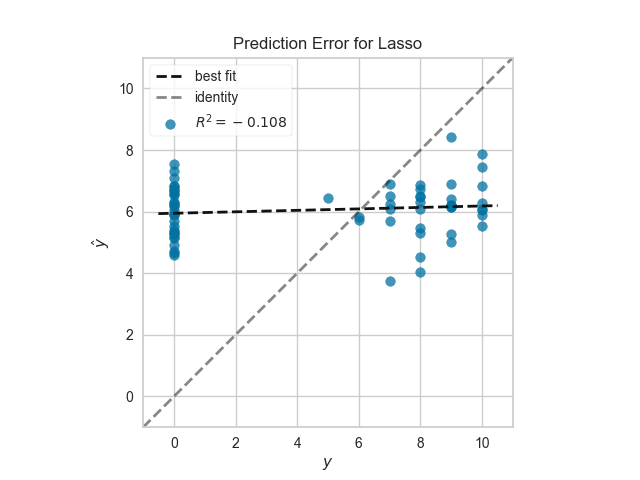

In [40]:
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError
%matplotlib notebook

regressor = Lasso(alpha=0.06)
visualizer = PredictionError(regressor)
visualizer.fit(X_train, y_train)
visualizer.score(X_dev_test, y_dev_test) 
visualizer.poof()